# Home depot competition solution
In this competition, Home Depot is asking Kagglers to help them improve their customers' shopping experience by developing a model that can accurately predict the relevance of search results.

Search relevancy is an implicit measure Home Depot uses to gauge how quickly they can get customers to the right products. Currently, human raters evaluate the impact of potential changes to their search algorithms, which is a slow and subjective process. By removing or minimizing human input in search relevance evaluation, Home Depot hopes to increase the number of iterations their team can perform on the current search algorithms.

In [2]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

# preprocess
import re  
import hunspell
from spellchecker import SpellChecker

#Feature engineering
from difflib import SequenceMatcher  # for LCS


# Different models
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

# Evaluation
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Visualization
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline

#Validation
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

In [3]:
raw_data_path = "../data/raw/"
preprocessed_data_path = "../data/processed/"

# LOAD RAW DATA

In [3]:
train = pd.read_csv(raw_data_path + "train.csv", encoding="ISO-8859-1")
attributes = pd.read_csv(
    raw_data_path + "attributes.csv", encoding="ISO-8859-1")
descriptions = pd.read_csv(
    raw_data_path + "product_descriptions.csv", encoding="ISO-8859-1")

display("Train:", train.head(), train.shape)
display("Attributes:", attributes.head(), attributes.shape)
display("Product descriptions:", descriptions.head(), descriptions.shape)

'Train:'

,id,product_uid,product_title,search_term,relevance
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67


(74067, 5)

'Attributes:'

,product_uid,name,value
0,100001.0,Bullet01,Versatile connector for various 90Â° connectio...
1,100001.0,Bullet02,Stronger than angled nailing or screw fastenin...
2,100001.0,Bullet03,Help ensure joints are consistently straight a...
3,100001.0,Bullet04,Dimensions: 3 in. x 3 in. x 1-1/2 in.
4,100001.0,Bullet05,Made from 12-Gauge steel


(2044803, 3)

'Product descriptions:'

,product_uid,product_description
0,100001,"Not only do angles make joints stronger, they ..."
1,100002,BEHR Premium Textured DECKOVER is an innovativ...
2,100003,Classic architecture meets contemporary design...
3,100004,The Grape Solar 265-Watt Polycrystalline PV So...
4,100005,Update your bathroom with the Delta Vero Singl...


(124428, 2)

# EDA

## MIssing values

In [6]:
print("None values count:")
print("\nTrain:", train.isna().sum(), "\nAttributes:", attributes.isna().sum(),
                                "\nDescriptions:", descriptions.isna().sum(), sep='\n')

None values count:

Train:
id               0
product_uid      0
product_title    0
search_term      0
relevance        0
dtype: int64

Attributes:
product_uid     155
name            155
value          2284
dtype: int64

Descriptions:
product_uid            0
product_description    0
dtype: int64


#### Conclusion: 
* No missing values in train.csv and product_descriptions.csv datasets, hence no treatment needed
* There are missing values in attributes.csv, additional research required

In [7]:
attributes[attributes.isnull().any(axis=1)].head(10)

,product_uid,name,value
1022,100044.0,Collection Name,NaN
1349,100058.0,Battery Size,NaN
1929,NaN,NaN,NaN
4094,NaN,NaN,NaN
4100,NaN,NaN,NaN
5909,100248.0,Fastener Thread Type,NaN
6367,100266.0,Drive Style,NaN
6823,NaN,NaN,NaN
7898,100329.0,Fastener recommendation,NaN
7901,100329.0,MFG Brand Name,NaN


#### Conclusion:
* All NaN rows cans be simply thrown away without hesitation
* It appears that attribute's name is meaningless without value. Also, this type of missing value comprises only ~2% of the whole dataset. Let's try to throw away this too

## Class balance

In [28]:
scores = train.iloc[:, 4].round(0)
scores.value_counts()

2.0    34614
3.0    34338
1.0     5115
Name: relevance, dtype: int64

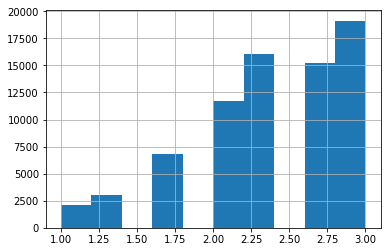

In [29]:
scores = train.iloc[:, 4]
scores.hist()

#### Conclusion: distribution is heavily shifted towards higher scores, hence accuracy may suffer

## Outliers

In [ ]:
# TODO

# MANUAL DATA INSPECTION

## Train.csv
### Observations:
* Dictionary word correction and lemmatization are needed for search_term column
* Lemmatization should be enough for product title, but it probably fine to play it safe and apply dictionary word correction too
* Standart text preprocessing is needed: remove stop words (have to do it first, to get rid from "in" **but not "in."**), dots, semicolons and any funny non-letter non-digit (might be exceptions, like measurment units and fractions) symbols etc. 
* **Symbols to remove**
    * `.`
    * `,`
    * `&`
    * `#`
    * `()`
    * `-`
    
* **Some measurment units are essentially same**, but written differently, like "in." and "inch", or "ft." and "feet", gonna deal with it somehow
    * Inches synonyms: 
        * \'\' (they follow immediately after the number)
        * in.
        * inches
    * Feet synonyms: 
        * \' (they follow immediately after the number) 
        * ft.
        * feet
    * Pound synonyms:
        * \#  (?) unsure
        * lb
        * lbs
        * pound
    * Cubic inch:
        * cu. in.
        * cubic inch
    * Cubic feet:
        * cu. ft.
        * cubic feet
        * cubic foot
    * Gallons synonyms:
        * gal.
        * gallon
    * Yards synonyms:
        * yds. 
        * yards
    * Angstrom, synonyms:
        * å¡
        * å
* `4x6` - these should look like this: `4 x 6`
* Have to split words by capital letter, digits (if they contain them inside)
* There are a lot of `*number* in./ft. x *number* in./ft.` **but query contains only `*number* x *number*`**; have to deal with this one somehow
* `by` is synonym to `x`  
* Some words are written by all caps, should convert it to usual word with on capital letter





#  Train.csv text preprocessing summarization:


1. Remove all in list: `[',', '(', ')', '#', '&']`, replace `['-', '+']` by whitespace
1. Replace equivalent measurments by their common synonym
1. Split words by capital letter or/and digits (if they contain them inside)
1. To lowercase everything
1. Remove all double/triple/etc whitespaces
1. Replace `by` by `x`
1. For each word compute the closest word from our dictionary; of the word is too far leave it as it is
1. Lemmatize each word 
1. Create another dictionary of all words from dataset and replace words by tokens

In [47]:
train.loc[train['product_title'].str.contains("å¡")].head() # excuse me what the fuck

,id,product_uid,product_title,search_term,relevance
323,1060,100179,Paslode 3 in. x 0.120-Gauge 30å¡ Galvanized Ri...,galvanized framing nails,2.67
324,1062,100179,Paslode 3 in. x 0.120-Gauge 30å¡ Galvanized Ri...,paslode framing nails,3.00
2304,7065,101205,Grip-Rite #8 x 3 in. 16å¡ Bright Steel Duplex ...,framing nails,2.33
2620,8092,101367,DEWALT 20-Volt Max XR Lithium-Ion Cordless Bru...,dewalt xr,3.00
2621,8094,101367,DEWALT 20-Volt Max XR Lithium-Ion Cordless Bru...,lithium 20 dewalt,2.67


## Attributes.csv
### Observations:
* Bullet*somenumber* is meaningless. It's value is what matters
* If value is missing or is equal to "No", the row probaly should be ignored

### Preprocessing summarization:
1. Throw away rows with missing values or "no" in it
2. Join attributes for each product into one like this: `first_attribute_name + " " + first_attribute_value + " " second_attribute_name + second_attribute_value + ` and so on (but be sure not to include `bullet*somenumber*`)
3. Apply same tranformation as to train.csv


## Product descriptions
### Preprocessing summarization:
1. Apply same transormations as to train.csv

# TEXT PREPROCESSING

### Preprocessing helpers

In [72]:
# Fix words
# SymSpell
import os

from symspellpy.symspellpy import SymSpell, Verbosity  


# maximum edit distance per dictionary precalculation
max_edit_distance_dictionary = 2
prefix_length = 4

# create object
sym_spell = SymSpell(max_edit_distance_dictionary, prefix_length)

# load dictionary      
dictionary_path = "/home/vladislav/Documents/home-depot/data/interim/frequency_dictionary_en_82_765.txt"
term_index=0  # column of the term in the dictionary text file
count_index=1  # column of the term frequency in the dictionary text file
if not sym_spell.load_dictionary(dictionary_path, term_index, count_index):
    print("Dictionary file not found")
    raise ValueError

# max edit distance per lookup
# (max_edit_distance_lookup <= max_edit_distance_dictionary)
max_edit_distance_lookup=2
suggestion_verbosity=Verbosity.CLOSEST  # TOP, CLOSEST, ALL


input_term = 'memeber'
suggestions=sym_spell.lookup(input_term, suggestion_verbosity, max_edit_distance_lookup)
# display suggestion term, term frequency, and edit distance
for suggestion in suggestions:
    print("{}, {}, {}".format(suggestion.term, suggestion.distance,
                              suggestion.count))

def correct(word):
    suggestions=sym_spell.lookup(word, suggestion_verbosity,
                                   max_edit_distance_lookup)
    return suggestions[0].term
correct('term')
def correct_words(s):
    sentence = []
    for word in s.split():
        if len(word) > 4:
            try:
                suggestion = correct(word)
                sentence.append(suggestion)
            except IndexError:
                sentence.append(word)
        else:
            sentence.append(word)
    return ' '.join(sentence)
    
 

member, 1, 283858893


In [12]:
# remove and replace unnecessary chars

chars_to_remove = [',', '\(', '\)', '#', '\&', ';']
chars_to_replace = ['-', '\+']

str_rem = "|".join(chars_to_remove)
str_rep = "|".join(chars_to_replace)


def remove_amp(s):
    return s.replace('&amp;', ' ')


def remove_chars(s):
    return re.sub(str_rem, "", s)


def replace_chars(s):
    return re.sub(str_rep, " ", s)


def string_punctuation_prep(s):
    s = remove_amp(s)
    s = remove_chars(s)
    s = replace_chars(s)
    return s

In [13]:
# Split words by capital letter or/and digits (if they contain them inside)

capitals_regex = re.compile('[A-Z]+[^A-Z]*|[^A-Z]+')
digits_regex = re.compile('\d+|\D+')


def split_by_capital(s):
    if re.match("[A-Z]+", s) is not None:  # If s contains capital letters
        words = capitals_regex.findall(s)
        words = map(str.strip, words)
        s = " ".join(words)
    return s


def split_by_digit(s):
    if re.search("[0-9]+", s) is not None:  # If s contains digits
        words = digits_regex.findall(s)
        words = map(str.strip, words)
        s = " ".join(words)
    return s


def string_cap_dig_split(s):
    s = split_by_capital(s)
    s = split_by_digit(s)
    return s

In [74]:
def string_replace_units(s):
    s = s.replace('\'\'',' in')
    s = s.replace(' in.',  ' in')
    s = s.replace(' inches',   ' in')
    
    s = s.replace('\'', ' ft')
    s = s.replace(' ft.', ' ft')
    s = s.replace(' feet',  ' ft')
    s = s.replace(' foot',  ' ft')
    
    s = s.replace(' lb.',  ' pound')
    s = s.replace(' lbs.', ' pound')
    
    s = s.replace(' cu.', ' cubic')
    
    s = s.replace(' gal.', ' gallon')
    
    s = s.replace(' yds.', ' yards')
    
    s = s.replace('å¡', ' angstrom')
    s = s.replace('å', ' angstrom')

    return s




In [75]:
# lower text
def lower(s):
    return s.lower()


# remove text
def remove_mult_spaces(s):
    return re.sub(' +', ' ', s).strip()


# replace 'by' by 'x'
def by_to_x(s):
    return s.replace(' by ', ' x ')

def remove_at(i, s):
    return s[:i] + s[i+1:]

# remove dots on the end of the word
def remove_dots(s):
    if re.search(r'[a-zA-Z]\.', s) is not None:
        s = s.replace('.', '')
    return s

        
def string_other_preprocessing(s):
    s = lower(s)
    s = remove_mult_spaces(s)
    s = by_to_x(s)
    s = remove_dots(s)
    return s



In [76]:
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
#nltk.download('punkt')

Lem = WordNetLemmatizer()

def string_lemmatize(s):
    words = [Lem.lemmatize(w) for w in word_tokenize(s)]
    s = ' '.join(words)
    return s

Stemmer=PorterStemmer()

def string_stem(s):
    words = [Stemmer.stem(w) for w in word_tokenize(s)]
    s = ' '.join(words)
    return s


#string_stem('mdf')

### Main helpers

In [77]:
# main helpers

def process_row(row, func):
    new_row = []
    for s in row:
        s = func(s)
        new_row.append(s)
    return pd.Series(new_row)

def punctuation_prep(row):
    return process_row(row, string_punctuation_prep)


def replace_units(row):
    return process_row(row, string_replace_units)


def cap_dig_split(row):
    return process_row(row, string_cap_dig_split)


def other_preprocessing(row):
    return process_row(row, string_other_preprocessing)


def lemmatize(row):
    return process_row(row, string_lemmatize)

def stem(row):
    return process_row(row, string_stem)


In [78]:
def prepare_dataset(dataset):    
    display(dataset)
    is_train = False
    if 'search_term' in dataset.columns:
        is_train = True
    
    # 1 Remove all in list: [',', '(', ')', '#', '&'], replace ['-', '+'] by whitespace
    dataset = dataset.apply(punctuation_prep, axis=1)

    # 2 Replace units
    dataset = dataset.apply(replace_units, axis=1)
    
    # 3 Split by capitals and digits
    dataset = dataset.apply(cap_dig_split, axis=1)
    
    # 4 Lower, remove whitespaces and by to x replacement
    dataset = dataset.apply(other_preprocessing, axis=1)
    
 
    #dataset.columns = ['product_title', 'search_term'] 
    #if is_train:
    #    dataset['search_term'] = dataset['search_term'].apply(lambda row: pd.Series([correct_words(row)]))
    
    # 5 Lemmatize
    dataset = dataset.apply(lemmatize, axis=1)
    
    #5 Stemmatize
    #dataset = dataset.apply(stem, axis=1)
    
    return(dataset)


### Train.csv

In [79]:
prep_train = train.copy()


dataset = prep_train[["product_title", "search_term"]]

prep_train[["product_title", "search_term"]] = parallelize(dataset, prepare_dataset)
#prep_train[["product_title", "search_term"]] = prepare_dataset(dataset.head(10))



prep_train.to_csv(preprocessed_data_path + "train.csv", index=False) 
display(prep_train[["product_title", "search_term"]].head(13), prep_train.shape)

,product_title,search_term
0,simpson strong tie 12 gauge angle,angle bracket
1,simpson strong tie 12 gauge angle,l bracket
2,behr premium textured deck over 1 gallon sc 14...,deck over
3,delta vero 1 handle shower only faucet trim ki...,rain shower head
4,delta vero 1 handle shower only faucet trim ki...,shower only faucet
5,whirlpool 1 . 9 cubic ft over the range convec...,convection otr
6,whirlpool 1 . 9 cubic ft over the range convec...,microwave over stove
7,whirlpool 1 . 9 cubic ft over the range convec...,microwave
8,lithonia lighting quantum 2 light black led em...,emergency light
9,house of fara 3 / 4 in x 3 in x 8 ft mdf flute...,mdf 3 / 4


(74067, 5)

### Product_descriptions.csv

In [60]:
prep_desc = descriptions.copy()


dataset = prep_desc[["product_description"]]
prep_desc[["product_description"]] = parallelize(dataset, prepare_dataset)


prep_desc.to_csv(preprocessed_data_path + "product_descriptions.csv", index=False) 
display(prep_desc.head(10), prep_desc.shape)

#1 Punctuation removed
#1 Punctuation removed
#1 Punctuation removed
#1 Punctuation removed
#1 Punctuation removed
#1 Punctuation removed
#1 Punctuation removed
#1 Punctuation removed
#2 Units replaced
#2 Units replaced
#2 Units replaced
#2 Units replaced
#2 Units replaced
#2 Units replaced
#2 Units replaced
#2 Units replaced
#3 Capitals and digits done
#3 Capitals and digits done
#3 Capitals and digits done
#3 Capitals and digits done
#3 Capitals and digits done
#3 Capitals and digits done
#3 Capitals and digits done
#3 Capitals and digits done
#4 Lower, remove whitespaces and by to x replacement
#4 Lower, remove whitespaces and by to x replacement
#4 Lower, remove whitespaces and by to x replacement
#4 Lower, remove whitespaces and by to x replacement
#4 Lower, remove whitespaces and by to x replacement
#4 Lower, remove whitespaces and by to x replacement
#4 Lower, remove whitespaces and by to x replacement
#4 Lower, remove whitespaces and by to x replacement
#5 Lemmatize
#5 Lemmatiz

,product_uid,product_description
0,100001,not only do angle make joint stronger they als...
1,100002,behr premium textured deckover is an innovativ...
2,100003,classic architecture meet contemporary design ...
3,100004,the grape solar 265 watt polycrystalline pv so...
4,100005,update your bathroom with the delta vero singl...
5,100006,achieving delicious result is almost effortles...
6,100007,the quantum adjustable 2 light led black emerg...
7,100008,the teks 10 x 1 1 / 2 inch zinc plated steel w...
8,100009,get the house of fara 3 / 4 inch x 3 inch x 8 ...
9,100010,valley view industry metal stake 4 pack are 9 ...


(124428, 2)

### Attributes.csv

In [10]:
prep_attr = attributes.copy()
prep_attr = prep_attr.dropna()
prep_attr.shape

(2042519, 3)

In [ ]:
# warning: wants additional ram, around 4 gb
dataset = prep_attr[["name", "value"]]
prep_attr[["name", "value"]] = parallelize(dataset, prepare_dataset, num_of_processes=7)
prep_attr.to_csv(preprocessed_data_path + "attributes.csv") 
display(prep_attr.head(10), prep_attr.shape)

In [20]:
prep_attr = prep_attr[prep_attr.value.str[0:2] != 'no']
prep_attr.to_csv(preprocessed_data_path + "attributes.csv", index=False) 
display(prep_attr.head(100), prep_attr.shape)

,product_uid,name,value
0,100001.0,bullet 01,versatile connector for various 90 â° connecti...
1,100001.0,bullet 02,stronger than angled nailing or screw fastenin...
2,100001.0,bullet 03,help ensure joint are consistently straight an...
3,100001.0,bullet 04,dimensions: 3 inch x 3 inch x 1 1 / 2 inch
4,100001.0,bullet 05,made from 12 gauge steel
5,100001.0,bullet 06,galvanized for extra corrosion resistance
6,100001.0,bullet 07,install with 10 d common nail or 9 x 1 1 / 2 i...
7,100001.0,gauge,12
8,100001.0,material,galvanized steel
9,100001.0,mfg brand name,simpson strong tie


(1906911, 3)

In [16]:
import gc
gc.collect()

115

# HELPERS

In [14]:
# LONGEST COMMON SUBSTRING
def longest_common_substring(m, n):
    seqMatch = SequenceMatcher(None, m, n)
    match = seqMatch.find_longest_match(0, len(m), 0, len(n))
    return m[match.a: match.a + match.size]

In [15]:
from multiprocessing import Pool
from functools import partial


def parallelize(data, func, num_of_processes=8):
    data_split = np.array_split(data, num_of_processes)
    pool = Pool(num_of_processes)
    data = pd.concat(pool.map(func, data_split))
    pool.close()
    pool.join()
    return data


def run_on_subset(func, data_subset):
    return data_subset.apply(func, axis=1)


def parallelize_on_rows(data, func, num_of_processes=8):
    return parallelize(data, partial(run_on_subset, func), num_of_processes)

# LOAD PREPROCESSED DATA

In [6]:
prep_train = pd.read_csv(preprocessed_data_path +
                    "train.csv", encoding="ISO-8859-1")
prep_attributes = pd.read_csv(
    preprocessed_data_path + "attributes.csv", encoding="ISO-8859-1")
prep_descriptions = pd.read_csv(
    preprocessed_data_path + "product_descriptions.csv", encoding="ISO-8859-1")

display("Train:", prep_train.head(10), prep_train.shape)
display("Attributes:", prep_attributes.head(), prep_attributes.shape)
display("Product descriptions:", prep_descriptions.head(), prep_descriptions.shape)

'Train:'

,id,product_uid,product_title,search_term,relevance
0,2,100001,simpson strong tie 12 gauge angle,angle bracket,3.00
1,3,100001,simpson strong tie 12 gauge angle,l bracket,2.50
2,9,100002,behr premium textured deck over 1 gallon sc 14...,deck over,3.00
3,16,100005,delta vero 1 handle shower only faucet trim ki...,rain shower head,2.33
4,17,100005,delta vero 1 handle shower only faucet trim ki...,shower only faucet,2.67
5,18,100006,whirlpool 1 . 9 cubic ft over the range convec...,convection otr,3.00
6,20,100006,whirlpool 1 . 9 cubic ft over the range convec...,microwave over stove,2.67
7,21,100006,whirlpool 1 . 9 cubic ft over the range convec...,microwave,3.00
8,23,100007,lithonia lighting quantum 2 light black led em...,emergency light,2.67
9,27,100009,house of fara 3 / 4 in x 3 in x 8 ft mdf flute...,mdf 3 / 4,3.00


(74067, 5)

'Attributes:'

,Unnamed: 0,product_uid,name,value
0,0,100001.0,bullet 01,versatile connector for various 90 Ã¢Â° connec...
1,1,100001.0,bullet 02,stronger than angled nailing or screw fastenin...
2,2,100001.0,bullet 03,help ensure joint are consistently straight an...
3,3,100001.0,bullet 04,dimensions: 3 inch x 3 inch x 1 1 / 2 inch
4,4,100001.0,bullet 05,made from 12 gauge steel


(1906911, 4)

'Product descriptions:'

,Unnamed: 0,product_uid,product_description
0,0,100001,not only do angle make joint stronger they als...
1,1,100002,behr premium textured deckover is an innovativ...
2,2,100003,classic architecture meet contemporary design ...
3,3,100004,the grape solar 265 watt polycrystalline pv so...
4,4,100005,update your bathroom with the delta vero singl...


(124428, 3)

# FEATURE ENGINEERING

## Plan for feature engineering
1. Merge attributes by uid
1. Create new dataset, that comprises:
    * Train
    * Merged attributes
    * Product descriptions
1. Create new bool feature: 1 when `train['product_title']` has same `*number* inch/feet x *number* inch/feet`  with `train['search_term']` (will also try lcs with it)
1. Create new bool feature: 1 when `train['product_title']` and `train['search_term']` have common number `*digit* [./] *digit*`
1. Create new int feature: Popularity for each product
1. Tokenize and vectorize each text feature


## Merge attributes by its product

In [7]:
prep_attributes.columns = ['idx', 'product_uid', 'name', 'value'] 
prep_attributes.sort_values(by=['product_uid', 'idx'], inplace=True)

In [8]:
# join attributes

dataset = []
prev_uid = None
result_attr = ''
for i in range(prep_attributes.shape[0]):

    cur_uid = prep_attributes['product_uid'][i]
    name = prep_attributes['name'][i]
    value = prep_attributes['value'][i]
    
    if prev_uid is not None:
        if prev_uid != cur_uid:
            dataset.append([prev_uid, result_attr.strip()])
            result_attr = ''
    
    if not 'bullet' in name:
        result_attr += name + ' '
    result_attr += value + ' '
    
    prev_uid = cur_uid
    
if result_attr is not '':
    dataset.append([cur_uid, result_attr.strip()])
    
merged_attributes = pd.DataFrame(dataset, columns=['product_uid', 'value'])
merged_attributes.to_csv(preprocessed_data_path + "merged_attributes.csv") 
display(merged_attributes.head(10))

,product_uid,value
0,100001.0,versatile connector for various 90 Ã¢Â° connec...
1,100002.0,application method brush roller spray assemble...
2,100003.0,built in flange yes slightly narrower for tigh...
3,100004.0,amperage amp 8 . 56 positive power tolerance 0...
4,100005.0,bath faucet type combo tub and shower includes...
5,100006.0,appliance type over the range microwave assemb...
6,100007.0,battery power type ni cad battery size .built ...
7,100008.0,assembled depth inch . 375 in assembled height...
8,100009.0,application door window made of primed mdf can...
9,100010.0,can be used with all valley view lawn edging a...


In [9]:
# set indicies
merged_attributes = merged_attributes.set_index('product_uid')
merged_attributes.index = merged_attributes.index.astype(int)
descriptions = descriptions.set_index('product_uid')
display(merged_attributes.head(2))
display(descriptions.head(2))

,value
product_uid,
100001,versatile connector for various 90 Ã¢Â° connec...
100002,application method brush roller spray assemble...


,Unnamed: 0,product_description
product_uid,,
100001,0,not only do angle make joint stronger they als...
100002,1,behr premium textured deckover is an innovativ...


## Popularity score

In [10]:
unique, counts = np.unique(prep_train['product_uid'].values, return_counts=True)

popularity = pd.DataFrame([unique, counts]).transpose()
popularity.columns = columns=['prod_uid', 'count']
popularity = popularity.set_index('prod_uid')
popularity['count'] = popularity['count'].apply(lambda x: 2 if x > 1 else x)

In [11]:
popularity['count'].value_counts()

1    42765
2    11902
Name: count, dtype: int64

In [25]:
merged_attributes.loc[prod_uid][0]

'application type residential california residents:Ã¢Â\xa0 due to requirement from air quality management district in the state of california please use the map below to confirm whether you live in an area that requires the purchase of ultra low nox water heater due to ultra low nox requirement from air quality management district in the state of california please confirm that your shipping zip code is not restricted from the use of item that do not meet local qualification 38 gal tank provides ample hot water for household with 2 to 4 people natural gas water heater cost le to operate than electric model delivers 73 gal of hot water in the first hour 12 year limited warranty on tank and part for your convenience 3 year in home labor warranty for peace of mind 0 . 69 energy factor indicates an energy star qualified water heater maintenance free no filter to clean or replace electronic ignition system simplifies the startup process and eliminates the need for a pilot light electronic di

## Collect 3 datasets into one 

In [26]:
#Join all datasets into one

dataset = []
for i in range(prep_train.shape[0]):
    prod_uid = prep_train['product_uid'][i]    
    title = prep_train['product_title'][i]
    search_term = prep_train['search_term'][i]
    score = prep_train['relevance'][i]
    
    try:
        description = prep_descriptions.loc[prod_uid][2] # careful here, 2 is because of unnamed column, will fix later
    except KeyError:
        description = ''
        
    try:
        attribute = merged_attributes.loc[prod_uid][0]
    except KeyError:
        attribute = ''
    
    popular = popularity.loc[prod_uid][0]
    lcs = len(longest_common_substring(title, search_term))
    search_len = len(search_term.split(' '))
    title_len = len(title.split(' '))
    title_search_proportion = title_len/search_len
    
    #dataset.append([prod_uid, title, search_term, attributes, description, lcs, popular, score])
    
    dataset.append([prod_uid, title, search_term, 
                    attribute, description, lcs,
                    title_search_proportion, title_len,
                    search_len, popular, score])
#joined_train = pd.DataFrame(dataset, columns=['prod_uid', 'title', 'search_term', 'attributes', 'description', 'lcs', 'popularity', 'relevance'])
joined_train = pd.DataFrame(dataset, columns=['prod_uid', 'title', 'search_term', 'attributes', 'description', 'lcs', 'title_search_proportion', 'title_len', 'search_len', 'popularity', 'relevance'])

joined_train.head(10)


,prod_uid,title,search_term,attributes,description,lcs,title_search_proportion,title_len,search_len,popularity,relevance
0,100001,simpson strong tie 12 gauge angle,angle bracket,versatile connector for various 90 Ã¢Â° connec...,this deck wash kit offer a quick and convenien...,5,3.000000,6,2,2,3.00
1,100001,simpson strong tie 12 gauge angle,l bracket,versatile connector for various 90 Ã¢Â° connec...,this deck wash kit offer a quick and convenien...,1,3.000000,6,2,2,2.50
2,100002,behr premium textured deck over 1 gallon sc 14...,deck over,application method brush roller spray assemble...,the m 8 1 25 zinc plated steel flange nut 2 p...,9,7.000000,14,2,1,3.00
3,100005,delta vero 1 handle shower only faucet trim ki...,rain shower head,bath faucet type combo tub and shower includes...,take control of your garage stop replacing yar...,8,4.666667,14,3,2,2.33
4,100005,delta vero 1 handle shower only faucet trim ki...,shower only faucet,bath faucet type combo tub and shower includes...,take control of your garage stop replacing yar...,18,4.666667,14,3,2,2.67
5,100006,whirlpool 1 . 9 cubic ft over the range convec...,convection otr,appliance type over the range microwave assemb...,the samsung 1 7 cubic foot over the range mic...,11,8.500000,17,2,2,3.00
6,100006,whirlpool 1 . 9 cubic ft over the range convec...,microwave over stove,appliance type over the range microwave assemb...,the samsung 1 7 cubic foot over the range mic...,10,5.666667,17,3,2,2.67
7,100006,whirlpool 1 . 9 cubic ft over the range convec...,microwave,appliance type over the range microwave assemb...,the samsung 1 7 cubic foot over the range mic...,9,17.000000,17,1,2,3.00
8,100007,lithonia lighting quantum 2 light black led em...,emergency light,battery power type ni cad battery size .built ...,the progressive swing open framed one panel sh...,10,5.000000,10,2,1,2.67
9,100009,house of fara 3 / 4 in x 3 in x 8 ft mdf flute...,mdf 3 / 4,application door window made of primed mdf can...,stanley national hardware ha been a leading ma...,6,4.000000,16,4,1,3.00


## Craft new features: numbers overlap

In [27]:
def search_fractions(s):
    return re.findall('\d+ [/\.] \d+', s)


def fractions_overlap(s1, s2):
    frac1 = set(search_fractions(s1))
    frac2 = set(search_fractions(s2))
    overlap = frac1.intersection(frac2)
    if len(overlap) > 0:
        return 1
    else:
        return 0



num = '(?:\d+ [/\.] )?\d+' # match numbers like ['8', '3 . 5', '4 / 9']
unit = '(?: in| ft)?(?: [wh])?' #match optional units
regex = num + unit + ' x ' + num + unit + '(?:' + ' x ' + num + unit + ')?'
#regex = num + any_word + ' x ' + num + any_word + '(?:' + ' x ' + num + any_word + ')?'

print('Regex: ' + regex)

def search_dimensions(s):
    return list(map(remove_units, map(str.strip, (re.findall(regex, s)))))

def remove_units(s):
    return re.sub(' in| ft', '', s)

def dimensions_overlap(s1, s2):
    dim1 = set(search_dimensions(s1))
    dim2 = set(search_dimensions(s2))
    overlap = dim1.intersection(dim2) # how many exact matches

    return len(overlap)

#s1 = '3 / 4 x 2 . 3 ft x 2 . 3'
#s2 = '3 / 4 x 2 . 3 in'

s1 = 'marazzi montagna gunstock 6 in x 24 in glazed porcelain floor and wall tile 14 53 sq ft / case'
s2 = 'porcelin floor tile 6 x 24'
dimensions_overlap(s1, s2)
#search_dimensions(s1)

Regex: (?:\d+ [/\.] )?\d+(?: in| ft)?(?: [wh])? x (?:\d+ [/\.] )?\d+(?: in| ft)?(?: [wh])?(?: x (?:\d+ [/\.] )?\d+(?: in| ft)?(?: [wh])?)?


1

In [28]:
display(joined_train.head(1))

,prod_uid,title,search_term,attributes,description,lcs,title_search_proportion,title_len,search_len,popularity,relevance
0,100001,simpson strong tie 12 gauge angle,angle bracket,versatile connector for various 90 Ã¢Â° connec...,this deck wash kit offer a quick and convenien...,5,3.0,6,2,2,3.0


In [29]:
#popularity
def craft_features(joined_train):

    frac_overlap = []
    dim_overlap = []
    for i in range(joined_train.shape[0]):
        search = joined_train['search_term'][i]
        title = joined_train['title'][i]
        #attribute = joined_train['attributes'][i]
        #description = joined_train['description'][i]
        
        #text = ' '.join([title, attribute, description])
        frac_overlap.append(fractions_overlap(search, title))
        dim_overlap.append(dimensions_overlap(search, title))
        
    return [pd.Series(frac_overlap), pd.Series(dim_overlap)]   
        
        
#
frac_overlap, dim_overlap = craft_features(joined_train)

print(np.unique(frac_overlap, return_counts=True))
print(np.unique(dim_overlap, return_counts=True))

(array([0, 1]), array([71802,  2265]))
(array([0, 1]), array([73156,   911]))


In [304]:
frac_overlap.shape

(74067,)

## Vectorization

In [30]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.  
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 50000) 


all_text = [joined_train['title'], joined_train['search_term'],
            joined_train['attributes'], joined_train['description']]
vectorizer.fit(pd.concat(all_text))

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=50000, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [31]:
# vectorize columns
titles_vector       = vectorizer.transform(joined_train['title'])
search_terms_vector = vectorizer.transform(joined_train['search_term'])
attributes_vector    = vectorizer.transform(joined_train['attributes'])
descriptions_vector = vectorizer.transform(joined_train['description'])

## Craft new features: overlap of grams between product data and query

In [32]:
titles_search_overlap = titles_vector.multiply(search_terms_vector).sum(axis=1)
descriptions_search_overlap = descriptions_vector.multiply(search_terms_vector).sum(axis=1)
attributes_search_overlap = attributes_vector.multiply(search_terms_vector).sum(axis=1)

## Concatenate features into one dataset

In [510]:
dataset = np.concatenate([titles_search_overlap, \
                          #descriptions_search_overlap, 
                          #attributes_search_overlap, 
                          #frac_overlap.values.reshape((-1, 1)),
                          #dim_overlap.values.reshape((-1, 1)),
                          joined_train['lcs'].values.reshape((-1, 1)),
                          joined_train['popularity'].values.reshape((-1, 1)),
                          joined_train['prod_uid'].values.reshape((-1, 1)),
                          joined_train['relevance'].values.reshape((-1, 1))],
                          axis=1)

In [33]:
dataset = pd.DataFrame(np.concatenate(
                      [#joined_train['prod_uid'].values.reshape((-1, 1)),
                       titles_search_overlap, \
                       descriptions_search_overlap, 
                       attributes_search_overlap, 
                       frac_overlap.values.reshape((-1, 1)),
                       dim_overlap.values.reshape((-1, 1)),
                       joined_train['lcs'].values.reshape((-1, 1)),
                       joined_train['popularity'].values.reshape((-1, 1)),
                       joined_train['title_len'].values.reshape((-1, 1)),
                       joined_train['title_search_proportion'].values.reshape((-1, 1)),
                       joined_train['search_len'].values.reshape((-1, 1)),
                       joined_train['relevance'].values.reshape((-1, 1))],
                       axis=1))

dataset[0] = dataset[0].astype(int)
dataset.columns = ['titles_search_overlap', 'descriptions_search_overlap', 'attributes_search_overlap', 'frac_overlap', 'dim_overlap', 'lcs', 'popularity', 'title_len', 'title_search_proportion', 'search_len', 'relevance']
dataset.head()

,titles_search_overlap,descriptions_search_overlap,attributes_search_overlap,frac_overlap,dim_overlap,lcs,popularity,title_len,title_search_proportion,search_len,relevance
0,1,0.0,0.0,0.0,0.0,5.0,2.0,6.0,3.000000,2.0,3.00
1,0,0.0,0.0,0.0,0.0,1.0,2.0,6.0,3.000000,2.0,2.50
2,2,0.0,5.0,0.0,0.0,9.0,1.0,14.0,7.000000,2.0,3.00
3,1,0.0,2.0,0.0,0.0,8.0,2.0,14.0,4.666667,3.0,2.33
4,3,0.0,7.0,0.0,0.0,18.0,2.0,14.0,4.666667,3.0,2.67


# MODEL

In [468]:
model = DecisionTreeRegressor()

In [430]:
model = RandomForestRegressor(n_estimators = 100)

In [459]:
model = LinearRegression()

In [34]:
import xgboost as xgb
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
model = xgb.XGBRegressor(objective='reg:squarederror')

In [169]:
# X, y = [dataset[:, 0:-1], dataset[:, -1]]
# print(X.shape, y.shape, dataset.shape)

(74067, 3) (74067,) (74067, 4)


(74067, 10) (74067,) (74067, 11)
Train score:  0.48344881618108115


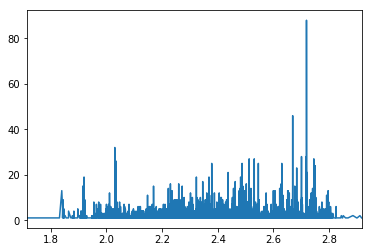

In [37]:
X, y = [dataset.iloc[:, 0:-1], dataset.iloc[:, -1]]
print(X.shape, y.shape, dataset.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train, np.ravel(y_train))
print('Train score: ', RMSE(model.predict(X_train), y_train))
y_preds = model.predict(X_test)
y_preds[y_preds<1] = 1
y_preds[y_preds>3] = 3
values = pd.Series(y_preds.reshape((-1))).value_counts() 
values.sort_index().plot(kind='line')


In [538]:
#if tree
#model.feature_importances_

#if xgboost
pd.DataFrame.from_dict(model.get_booster().get_score(importance_type='gain'), orient='index').sort_values(0,ascending=False)

,0
lcs,46.716495
titles_search_overlap,42.228814
search_len,28.661726
descriptions_search_overlap,18.427716
attributes_search_overlap,10.485194
frac_overlap,8.783736
dim_overlap,6.869429
popularity,4.998214
title_len,4.566174
title_search_proportion,1.964760


In [38]:
pd.DataFrame.from_dict(model.get_booster().get_score(importance_type='gain'), orient='index').sort_values(0,ascending=False)

,0
lcs,42.180553
titles_search_overlap,39.241055
search_len,27.406564
attributes_search_overlap,8.786738
dim_overlap,8.662545
frac_overlap,8.364251
title_len,5.502729
popularity,4.231545
title_search_proportion,2.119340
descriptions_search_overlap,1.258663


# Error analysis

In [545]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

diffs = y_test-y_preds
worst_mistakes = np.abs(diffs).sort_values(ascending = False)
display(worst_mistakes.head(5))
df = []
pred_rel = []
gram_overlap = []

for index in worst_mistakes.head(5).index.values:
    row = joined_train.loc[index] 
    pred_rel.append(dataset['relevance'].loc[index] - diffs.loc[index])                       
    #gram_overlap.append(dataset[0].loc[index].astype(int))
    df.append(row)

df = pd.DataFrame(df)

df['predicted'] = pred_rel 
#df['gram_overlap'] = gram_overlap
display(df)
    


21334    1.721101
31557    1.701550
43448    1.693135
57226    1.663914
45128    1.634149
Name: relevance, dtype: float64

,prod_uid,title,search_term,attributes,description,lcs,title_search_proportion,title_len,search_len,popularity,relevance,predicted
21334,118171,tree trainer small self supporting tree brace,small tree,,the tree trainer is an innovative product award winner through the american nursery and landscap...,6,3.500000,7,2,1,1.0,2.721101
31557,129999,brass craft 3 / 8 in o d x 36 in copper faucet riser in chrome,copper faucet,,brass craft 3 / 8 inch o d tube x 36 inch length chrome plated copper riser for faucet installat...,13,8.000000,16,2,1,1.0,2.701550
43448,146522,bona stone tile and laminate floor care system,laminate floor tile,hard surface floor cleaning kit includes mop microfiber cleaning pad microfiber dusting pad and ...,use the bona stone tile and laminate floor care system to clean hard surface floor in your home ...,15,2.666667,8,3,1,1.0,2.693135
57226,169903,prime line satin nickel door blocker entry door stop,gas door stop,builder hardware product type door stop designed to withstand 800 pound of force tamper resistan...,the entry door stop is constructed from aluminum and come finished in brass it protects against ...,10,3.000000,9,3,2,1.0,2.663914
45128,149071,viagrow strawberry planter vertical garden,strawberry,,the viagrow strawberry planter allows you to grow your own strawberry utilizing a vertical plant...,10,5.000000,5,1,1,1.0,2.634149


# EVALUATION

In [36]:
#RMSE
def RMSE(y_preds, y_test):
    return np.sqrt(mean_squared_error(y_preds, y_test))

#RMSE(y_preds, y_test)

In [39]:
# K-FOLD validation


scores = []
cv = KFold(n_splits=10, shuffle=True)
#X = X.values
for train_index, test_index in cv.split(X):
    #print("Train Index: ", train_index, "\n")
    #print("Test Index: ", test_index)

    X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
    model.fit(X_train, np.ravel(y_train))
    y_preds = model.predict(X_test)
    y_preds[y_preds<1] = 1
    y_preds[y_preds>3] = 3
    scores.append(RMSE(y_preds, y_test))

print(np.mean(scores))
display(pd.DataFrame(scores, columns=['Score']))



0.48471656908245764


,Score
0,0.494492
1,0.478728
2,0.484461
3,0.477595
4,0.485485
5,0.482109
6,0.483606
7,0.492322
8,0.483924
9,0.484443


### Baseline (train - search longest common substring), RMSE - 0.518, while: 
* best score on lb: 0.431
* all 1 submission score: 1.481
* all 2 submission score: 0.655
* all 3 submission score: 0.815
* Relevance mean score - 0.5356
### Best score so far:
* XGB regressor  0.48345

3362.490010444164

# INFERENCE DATA LOAD

In [28]:
submission = pd.read_csv(input_path + "test.csv", engine="python")
dataset = []
for i in range(submission.shape[0]):
    desc =  submission.iloc[i, 2]
    query = submission.iloc[i, 3]
    lcs = matchsubstring(desc.lower(), query.lower()) # longest common substring
    overlap = len(lcs)
    dataset.append([overlap])
dataset = np.array(dataset)
dataset.shape

(166693, 1)

# INFERENCE

In [29]:
res = model.predict(dataset)
pd.Series(res).value_counts() 

2.309699    20207
2.366322    19982
2.405317    16358
2.300432    14843
2.440167    12511
2.451519    10876
2.453807    10558
2.462379     9938
2.208040     7820
2.502626     7213
2.001926     7108
2.517936     5316
2.521558     4793
2.080039     4397
2.530338     3152
2.549126     2385
2.540354     2096
1.880398     1874
2.602454     1293
2.600461      914
2.661237      745
2.558575      555
2.620296      368
2.653108      286
2.679566      262
2.614865      163
2.511387      156
2.677061       92
2.631297       81
2.446669       60
2.577074       46
2.242688       42
1.863927       30
2.506648       24
2.704338       21
2.741713       21
2.751972       19
2.683192       13
2.620749       12
2.786805       12
2.773557        9
2.687377        9
2.791877        7
2.452969        4
2.340735        4
2.378362        4
2.712363        4
2.725701        4
2.337368        2
2.542676        2
2.623326        2
dtype: int64

# OUTPUT

In [30]:
res[res>3] = 3
res = pd.DataFrame(res, columns=['relevance'])
res['id'] = submission['id']
res = res[['id', 'relevance']]
res.head()

,id,relevance
0,1,2.001926
1,4,1.880398
2,5,2.440167
3,6,2.517936
4,7,2.517936


In [31]:
res.loc[res['relevance']>=3]

,id,relevance


In [32]:
res.to_csv('output.csv', index=False)

In [33]:
tmp = pd.read_csv("output.csv")
tmp.loc[tmp['relevance']>3]

,id,relevance


In [34]:
tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166693 entries, 0 to 166692
Data columns (total 2 columns):
id           166693 non-null int64
relevance    166693 non-null float64
dtypes: float64(1), int64(1)
memory usage: 2.5 MB


In [35]:
!head output.csv 

id,relevance
1,2.001926138644444
4,1.880398441318938
5,2.4401667969070053
6,2.517935886475066
7,2.517935886475066
8,2.001926138644444
10,2.6024539827454927
11,2.366322356378352
12,2.366322356378352
